## Uncertainty Prediction House Prices

In this notebook, we use one 'real' dataset: Boston house price dataset. We would like to **compare the MDN method with the technique proposed in the Experiment.I 'On fly variance estimation'**

MDN have been found to be a reference technique in the area of BDL with many applications such as speech generation (Apple’s Siri in iOS 11 ), generation of artificial handwriting or forecasting [1]

[1] https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca

<span style="color:red">
TODO: Buscar un método de validación valido para datasets multidimensionales, actualmente validamos los resultados visualizandolos
</span> 

####  Experiment configuration

<span style="color:red">
IMPORTANT!! This notebook includes two different techniques ('On fly variance estimation' 'MDN') which depend on Tensorflow 2.0 and Pytorch respectively. Both techniques are included here for readability and organizational purposes. You should run the notebook with the two following different configurations
</span> 

Notebook execution configuration steps:
* (1) Select the proper kernel Tensorflow 2.0 or Pytorch depending on the technique to be executed
* (2) Change the variables 'execute_techniqueI' or 'execute_MDN' accordingly

In [1]:
execute_techniqueI = False
execute_MDN = True 

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

if execute_MDN:
    import tensorflow as tf
    #tf.enable_eager_execution()
    from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
    import sys 
    sys.path.insert(0,'..')
    from utilities import model_mdn
    
if execute_techniqueI:
    import torch
    from torch.autograd import Variable
    import torch.nn.functional as F
    import statistics as stat

### 1. Boston dataset

*Why are we testing with the boston dataset?*

The boston dataset is commonly used as a reference dataset in most of the BDL benchmarks [2][3]. Assessing the performance of BDL techniques may become very difficult since the **'uncertainty' interpretation depends on the business domain**. There are many different valid interpretations (variance, prediction intervals, out-of-threshold prediction error etc.) . Here, **we focus in the business problem of predicting house prices in Boston and the variance as uncertainty metric**

[2] Filos, A., Farquhar, S., Gomez, A. N., Rudner, T. G. J., Kenton, Z., Smith, L., … Gal, Y. (2019). A Systematic Comparison of Bayesian Deep Learning Robustness in Diabetic Retinopathy Tasks. (NeurIPS), 1–12. Retrieved from http://arxiv.org/abs/1912.10481

[3] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. Advances in Neural Information Processing Systems, 2017-Decem(Nips), 6403–6414.

In [3]:
boston_dataset = load_boston()

In [4]:
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [5]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


We will use as **target of our prediction problem the variable MEDV** which represents the value of occupied homes in $1000's as it is described in the documentation of the dataset

In [7]:
boston['MEDV'] = boston_dataset.target

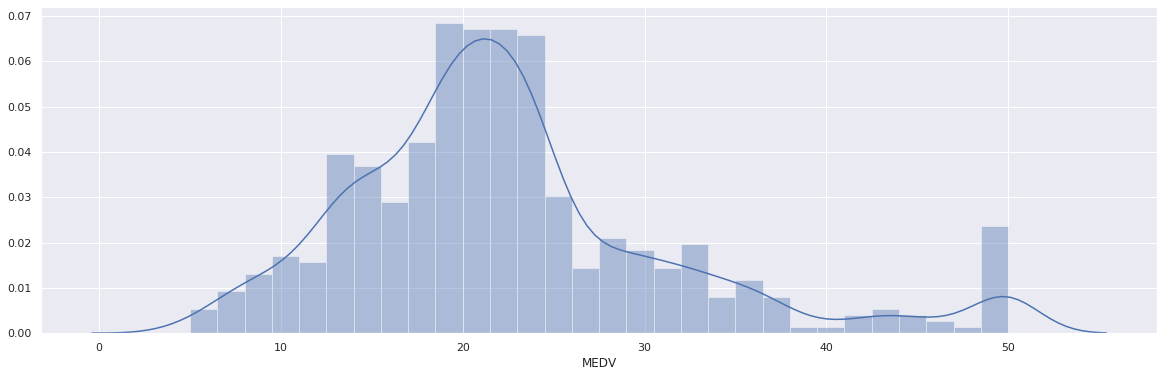

In [8]:
sns.set(rc={'figure.figsize':(20,6)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()

In this plot we can observe an assymmetric distribution of MEDV which most of the values are centered around 22. As the techniques used here approximates to conditional mean of Y E[Y|X], we expect the predicted distribution of P(Y|X) centered on these values [19,25] with a **lower error variance at these interval** and a **greater error variance in the tails of the distribution**

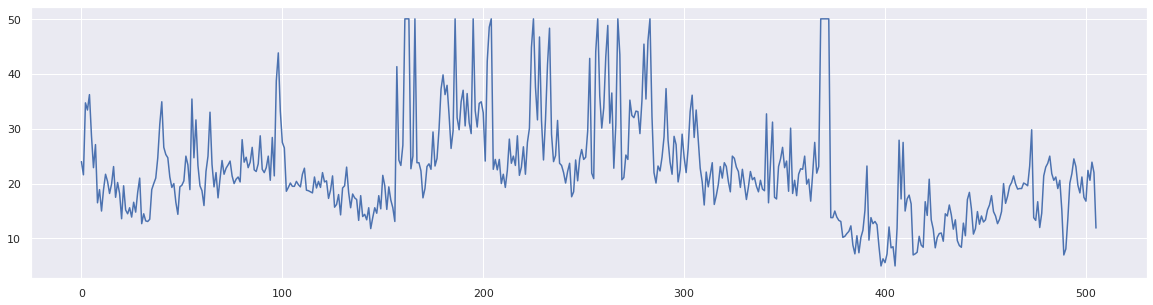

In [9]:
boston['MEDV'].plot(figsize=(20, 5))

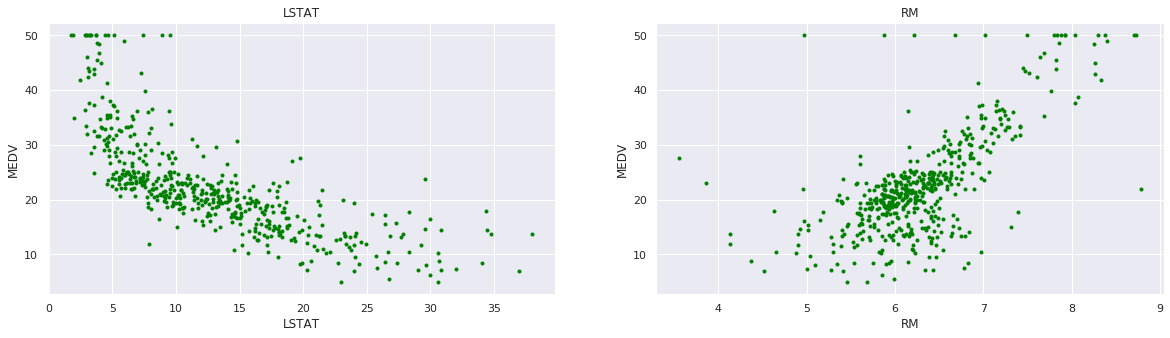

In [10]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.plot(x, y, '.', color= 'green')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In this plot, we can see a **clear correlation of the variables LSTAT and RM**. We found a negative correlation between MEDV and LSTAT and a positive correlation RM and MEDV. Additionally, we can observe that **both variables are heterocedastic with respect to MEDV**

### 2. Prepare data for training

Here, we will split the dataset and use 20% for testing

In [11]:
boston['MEDV'].size, boston['LSTAT'].size

(506, 506)

In [12]:
Y = pd.DataFrame(np.array([boston['MEDV']]).T, columns = ['y'])
X = pd.DataFrame(np.array([boston['LSTAT'], boston['RM']]).T, columns = ['LSTAT','RM'])

In [13]:
Y.tail()

,y
501,22.4
502,20.6
503,23.9
504,22.0
505,11.9


In [14]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split
x, x_val, y, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [15]:
x_train, x_val, y_train, y_val = x.values, x_val.values, y.values, y_val.values

In [16]:
y_train.size, x_train.size, x_val.size, y_val.size

(404, 808, 204, 102)

<Figure size 1008x432 with 0 Axes>

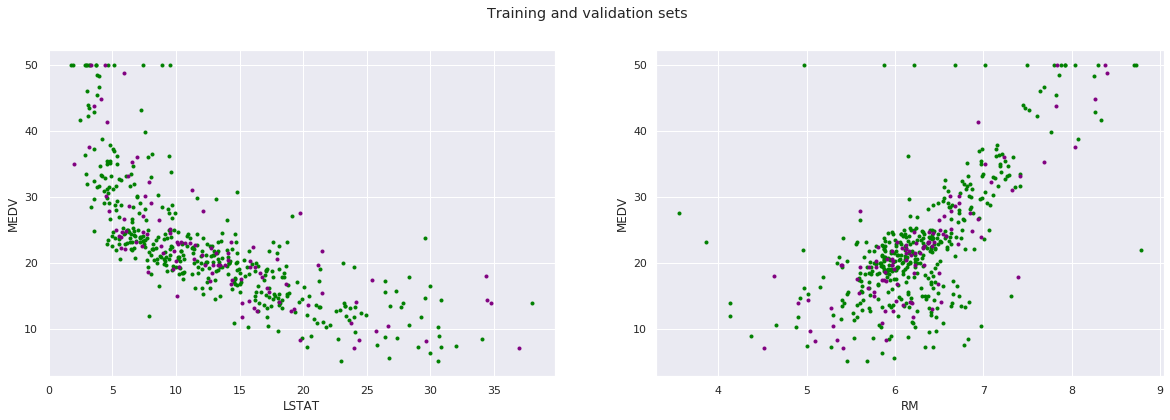

In [17]:
# Plot the data
plt.figure(figsize=(14,6))
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Training and validation sets')
ax1.plot(x_train[:,0], y_train, '.', color= 'green')
ax1.plot(x_val[:,0], y_val, '.', color='purple')
ax1.set(xlabel='LSTAT', ylabel='MEDV');
ax2.plot(x_train[:,1], y_train, '.', color= 'green')
ax2.plot(x_val[:,1], y_val, '.', color='purple')
ax2.set(xlabel='RM', ylabel='MEDV');

*Extra data-prepartion*: The technique.I needs to build a compound vector with the response target variable and sigma

In [18]:
y_train.shape

(404, 1)

In [19]:
if execute_techniqueI == True:
    # Convert x and y to PyTorch Variables on the GPU
    # Add in column of dummy zeros to represent sigma 
    sigma = np.zeros(y_train.shape)
    y_ = np.stack([y_train, sigma], axis=1)[:,:,0]
    dtype = torch.cuda.FloatTensor
    x_t = Variable(torch.from_numpy(x_train).type(dtype))
    y_t = Variable(torch.from_numpy(y_).type(dtype), requires_grad=False)

### 3. Model definition

#### Exp.I 'On fly variance estimation'

Create a simple network

In [21]:
if execute_techniqueI == True:
    
    # Create a simple two-layer network with one input (x) and two outputs (y, sigma)
    n_inputs = 2
    n_outputs = 2
    n_hidden = 1000
    model_1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                                torch.nn.ReLU(),
                                torch.nn.Linear(n_hidden, n_outputs)
                               ).cuda()
    # Adam optimizer
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

Custom loss function

In [22]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

#### Mixture Density Network

In [23]:
if execute_MDN == True:
    no_parameters = 3
    components = 1
    neurons = 200
    opt = tf.optimizers.Adam(1e-3)

    tf_path = os.path.join(os.getcwd(), 'tf_board')
    tensorboard = TensorBoard(log_dir=tf_path, histogram_freq=0, write_graph=True, write_images=False)
    mon = EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=2, verbose=0, mode='auto')
    
    mdn_ = model_mdn.MDN(neurons=neurons, components=components, no_parameters=no_parameters)
    mdn_.compile(loss=mdn_.gnll_loss, optimizer=opt)

### 4. Model training

#### Exp.I 'On fly variance estimation'

In [24]:
if execute_techniqueI == True:
    n_epochs = 10000
    for i in range(n_epochs):

        # Calculate predicted y from x
        y_pred = model_1(x_t)

        # Calculate loss
        loss = loss_variance_error(y_pred, y_t)
        if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

        # Backprop, first zeroing gradients
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step()

#### Mixture Density Network

In [25]:
if execute_MDN == True:
    mdn_.fit(
        x=x_train, 
        y=y_train, 
        epochs=10000, 
        validation_data=(x_val, y_val), 
        batch_size=128, 
        verbose=0
    )

### 5. Model Validation

Get predictions for validation set

#### Exp.I 'On fly variance estimation'

In [26]:
if execute_techniqueI == True:
    # Get predicted y and sigma for validation set
    x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
    pred_1 = model_1(x_val_t)

    # prediction of the response variables
    y_pred_1 = pred_1[:,0].cpu().data
    sigma_pred_1 = pred_1[:,1].cpu().data
    
    # print variable shape
    y_pred_1.data.shape, sigma_pred_1.shape, x_val_t[:,0].shape

#### Mixture Density Network

In [27]:
mdn_.summary()

Model: "MDN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   multiple                  600       
_________________________________________________________________
h2 (Dense)                   multiple                  40200     
_________________________________________________________________
alphas (Dense)               multiple                  201       
_________________________________________________________________
mus (Dense)                  multiple                  201       
_________________________________________________________________
sigmas (Dense)               multiple                  201       
_________________________________________________________________
pvec (Concatenate)           multiple                  0         
Total params: 41,403
Trainable params: 41,403
Non-trainable params: 0
___________________________________________________________

In [28]:
tensor = tf.constant([
    [1.0, 2.0]
], dtype='float32')


mdn_.predict(tensor)

array([[ 1.      , 63.555405, 85.86083 ]], dtype=float32)

In [29]:
if execute_MDN == True:

    mdn_alpha, mdn_mu, mdn_sigma = mdn_.slice_parameter_vectors(mdn_.predict(x_val))
    
    # print variable shape
    mdn_alpha.shape, mdn_mu.shape, mdn_sigma.shape

### 6. Result comparison

Here we compare the 'real sigma'*, which is the difference between the predictions and the validation data, with the predicted one.

* The real sigma is computed using the validation data. Thus, it is somehow representative of the true sigma but not exactly the real one (ee.g. new observations may follow a different distribution)

In [72]:
if execute_techniqueI:
    real_sigma_I = (y_pred_1.numpy()- y_val[:,0])**2
    print('Technique.I - Real sigma {} : Predicted sigma {}'.format(sum(real_sigma_I), sum(sigma_pred_1)))

Technique.I - Real sigma 1610.889389493673 : Predicted sigma 1528.9381103515625


In [37]:
if execute_MDN:
    real_sigma_mdn = (mdn_mu[:,0]- y_val[:,0])**2
    print('MDN - Real sigma {} : Predicted sigma {}'.format(sum(real_sigma_mdn), sum(mdn_sigma[:,0]**2)))

MDN - Real sigma 1620.795222233514 : Predicted sigma 1068.900887787342


We get better results with Technique.I

#### Plot predictions and their errors

<Figure size 1008x432 with 0 Axes>

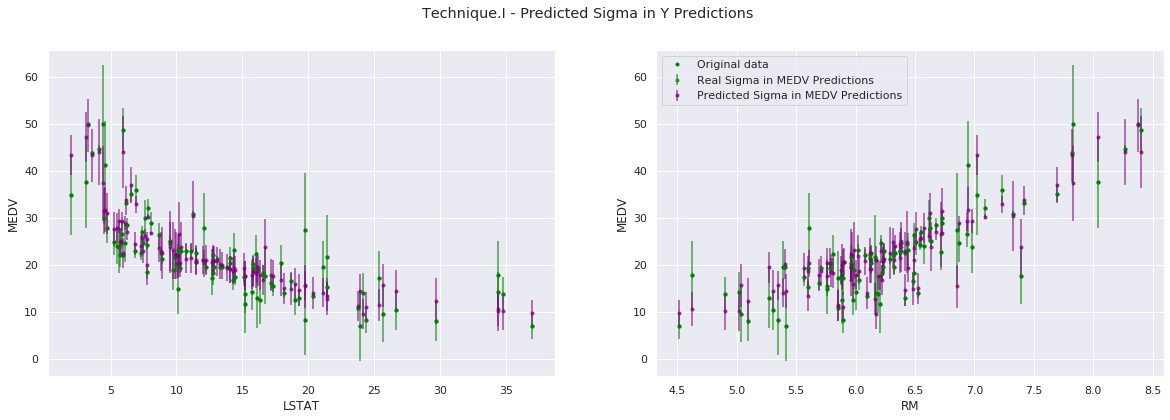

In [74]:
import warnings
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)

if execute_techniqueI:
    plt.figure(figsize=(14,6))
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('Technique.I - Predicted Sigma in Y Predictions')
    ax1.plot(x_val[:,0], y_val[:,0], '.', color='green')
    ax1.errorbar(x_val[:,0], y_val[:,0], yerr=np.sqrt(abs(real_sigma_I)), alpha=0.7, color='green', fmt='.'); 
    ax1.errorbar(x_val[:,0], y_pred_1, yerr=np.sqrt(abs(sigma_pred_1)) ,  alpha=0.7,color='purple', fmt='.'); 
    ax1.set_xlabel(r'LSTAT');
    ax1.set_ylabel(r'MEDV');
    ax2.plot(x_val[:,1], y_val[:,0], '.', color='green')
    ax2.errorbar(x_val[:,1], y_val[:,0], yerr=np.sqrt(abs(real_sigma_I)), alpha=0.7, color='green', fmt='.'); 
    ax2.errorbar(x_val[:,1], y_pred_1, yerr=np.sqrt(abs(sigma_pred_1)), alpha=0.7, color='purple', fmt='.'); 
    ax2.set_xlabel(r'RM');
    ax2.set_ylabel(r'MEDV');
    ax2.legend([r'Original data','Real Sigma in MEDV Predictions', 'Predicted Sigma in MEDV Predictions'], loc='upper left', );

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


<Figure size 1008x432 with 0 Axes>

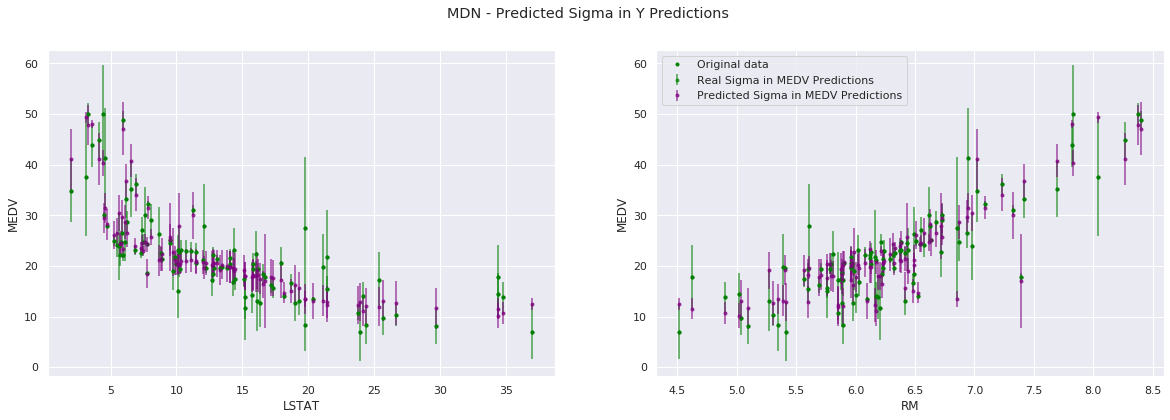

In [33]:
if execute_MDN:
    plt.figure(figsize=(14,6))
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('MDN - Predicted Sigma in Y Predictions')
    ax1.plot(x_val[:,0], y_val[:,0], '.', color='green')
    ax1.errorbar(x_val[:,0], y_val[:,0], yerr=np.sqrt(abs(real_sigma_mdn)), alpha=0.7, color='green', fmt='.'); 
    ax1.errorbar(x_val[:,0], mdn_mu, yerr=abs(mdn_sigma) ,  alpha=0.7,color='purple', fmt='.'); 
    ax1.set_xlabel(r'LSTAT');
    ax1.set_ylabel(r'MEDV');
    ax2.plot(x_val[:,1], y_val[:,0], '.', color='green')
    ax2.errorbar(x_val[:,1], y_val[:,0], yerr=np.sqrt(abs(real_sigma_mdn)), alpha=0.7, color='green', fmt='.'); 
    ax2.errorbar(x_val[:,1], mdn_mu, yerr=abs(mdn_sigma), alpha=0.7, color='purple', fmt='.'); 
    ax2.set_xlabel(r'RM');
    ax2.set_ylabel(r'MEDV');
    ax2.legend([r'Original data','Real Sigma in MEDV Predictions', 'Predicted Sigma in MEDV Predictions'], loc='upper left', );

### Conclusions


* We get similar results with MDN and Technique.I. However, Technique.I outperforms MDN using a similar model architecture. This evaluation has been made under the following conditions:
    * We have only 2 independent variables in the dataset. We have reduce a lot the dimensionality to be able to compare it.
    * We have fitted the MDN using one gaussian kernel
* The predicted sigma is smoothed in both cases. We approximate to the mean
* MDN lets you play easily with different family distributions. This is important to be able to select the best priorç


### Future Steps

* We need a proper method for evaluating the sigma prediction using multidimensional data. 
* We need to test the MDN using all variables of the dataset. This scenario may change the selection of the best technique since Technique.I is limited in this case
* It might be interesting to play with different family distributions
* It might be interesting to play with the number of kernels (Multimodality approximation)

* Try a technique with a classification dataset